In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from datetime import datetime
import matplotlib.dates as mdates

import scipy.stats
from scipy.stats import spearmanr
from scipy.stats import pearsonr

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

# 1. Saskatchewan Clinical Data and Visualization

<ipython-input-70-cd584ef176af>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_clin.COVID[k]=np.average(clin1.COVID_Cases[i:i+7])
<ipython-input-70-cd584ef176af>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_clin.FLU[k]=np.average(clin1.Flu_Cases[i:i+7])
<ipython-input-70-cd584ef176af>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_clin.RSV[k]=np.average(clin1.RSV_Cases[i:i+7])
<ipython-input-70-cd584ef176af>:14: 

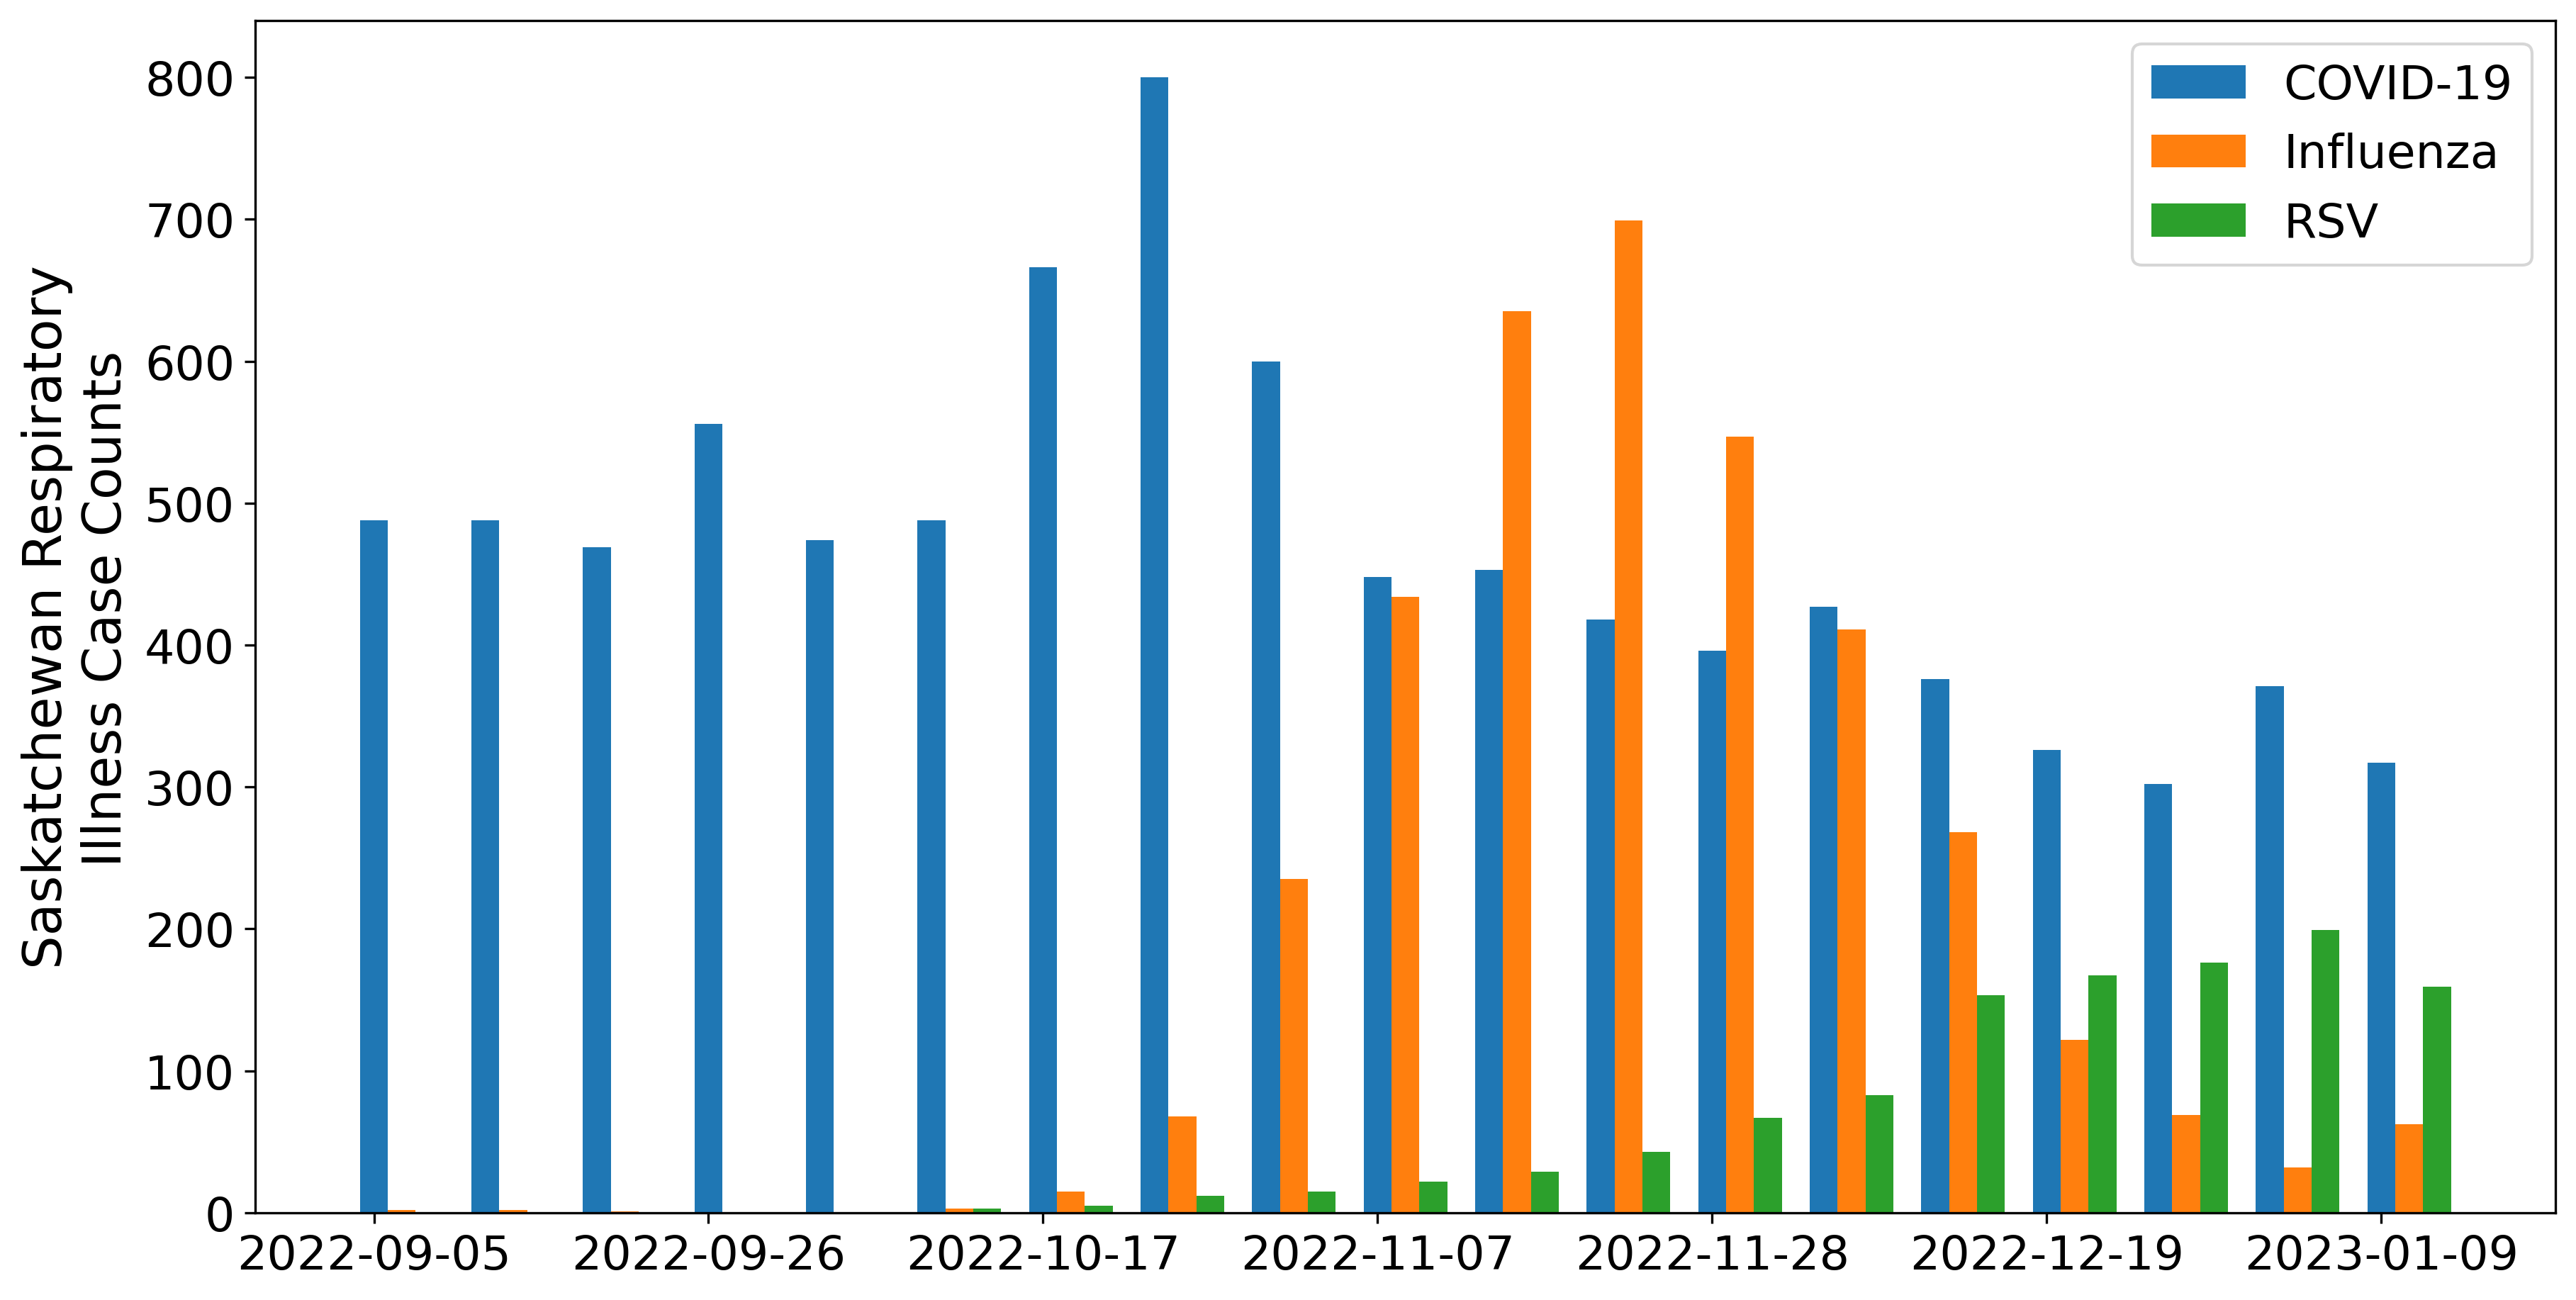

In [70]:
#####  SASKATCHEWAN Clinical DATA  #####
clin=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\GeneXpert\ClinicalData_CRISP_Report.xlsx",sheet_name="Sheet2")

clin1=clin ### Diagram for RSV, COVID, and Flu case variabilites
clin1 = clin1[clin1['Report_Date'].notna()]


#### 7-day average for Clinical Data Plotting
avg_clin = pd.DataFrame(np.zeros((int(clin1.shape[0]/7), 4)),columns=['Date','COVID','FLU','RSV']) #Creat a dataframe with size and cloumn

k=0
for i in range(0, clin1.shape[0],7): #Because the data starts from 
    
    avg_clin.Date[k]=clin1.Report_Date[i+1]
    avg_clin.COVID[k]=np.average(clin1.COVID_Cases[i:i+7])
    
    
    avg_clin.FLU[k]=np.average(clin1.Flu_Cases[i:i+7])
    avg_clin.RSV[k]=np.average(clin1.RSV_Cases[i:i+7])
    k=k+1
avg_clin['Date'] = pd.to_datetime(avg_clin['Date']).dt.date    

## Plot Clinical data

X_axis = np.arange(len(avg_clin.Date))
fig, ax1 = plt.subplots(figsize=(12,6),dpi=300,constrained_layout=True)


ax1.bar(X_axis, avg_clin.COVID, width=0.25)
ax1.bar(X_axis+0.25, avg_clin.FLU, width=0.25)
ax1.bar(X_axis+0.5, avg_clin.RSV, width=0.25)

#plt.xticks(X_axis, avg_clin.Date)
#plt.locator_params(axis='x', nbins=6)
##ax1.set_xticklabels(avg_clin.Date)

# Modify x-axis labels to show the end of December
end_of_december = pd.to_datetime('2023-01-04').date()
avg_clin.Date[-1] = end_of_december
plt.xticks(X_axis, avg_clin.Date)
plt.locator_params(axis='x', nbins=8)


ax1.set_ylabel('Saskatchewan Respiratory\n Illness Case Counts',fontsize=18)
ax1.legend(labels=['COVID-19', 'Influenza','RSV'],fontsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
#ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15))


#plt.xlabel('Sampling Date',fontsize=16)
plt.show()

# 2. Influenza A Virus (IAV) in Saskatoon

### 2.1. Correlation test for the determination of Lead/Lag time

In [84]:
clin=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\GeneXpert\ClinicalData_CRISP_Report.xlsx",sheet_name="Sheet2")

clin[["Flu_Cases"]]= clin[["Flu_Cases"]].shift(10)


#Data inputs for Routine and wastewater Flu and Covid
### ROUTINE DATA
R_Flu=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\GeneXpert\Conversion Formula_Flue.xlsx",sheet_name="Influenza A_SK_R")

#Removing Coloumns and Rows
R_Flu.drop(['Unnamed: 0','Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 7','Unnamed: 8','Unnamed: 9'],axis=1, inplace=True) #Remove Comment Column
R_Flu.drop(labels=[0,1],axis=0, inplace=True) #Remove Row with Lables 0 and 1

#Renaming
R_Flu = R_Flu.rename(columns={'Unnamed: 1':'Date','Unnamed: 6':'Flu_R'})
R_Flu.dropna(axis=0,inplace=True) # Drop NAN values

## Convert date HH MM SS to DAte
R_Flu['Date'] = pd.to_datetime(R_Flu['Date']).dt.date #Convert date HH MM SS to DAte

###     ####### #####  WHOLE WASTEWATER DATA #####    ######   #####
W_Flu=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\GeneXpert\Conversion Formula_Flue.xlsx",sheet_name="Influenza A_SK_W")

#Removing Coloumns and Rows
W_Flu.drop(['Unnamed: 0','Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 7','Unnamed: 8','Unnamed: 9'],axis=1, inplace=True) #Remove Comment Column
W_Flu.drop(labels=[0,1],axis=0, inplace=True) #Remove Row with Lables 0 and 1
#Renaming
W_Flu = W_Flu.rename(columns={'Unnamed: 1':'Date','Unnamed: 6':'Flu_W'})
W_Flu.dropna(axis=0,inplace=True) # Drop NAN values
W_Flu['Date'] = pd.to_datetime(W_Flu['Date']).dt.date #Convert date HH MM SS to DAte

flu_final=pd.concat([R_Flu,W_Flu.Flu_W],axis=1)
flu_final["Cases"] = ""

for index, row in clin.iterrows():
    date = row['Report_Date']
    cases = row['Flu_Cases']
    matching_row = flu_final[flu_final['Date'] == date]
    if not matching_row.empty:
        flu_final.loc[matching_row.index, 'Cases'] = cases

flu_final.dropna(axis=0,inplace=True)
flu_final.drop(index=flu_final.index[-1],axis=0,inplace=True)

### -------------- CORRELATION   TEST-----------###
flu_final=flu_final.dropna(axis=0)

cor_flu_case, pvalue_flu_case=spearmanr(flu_final.drop(['Date'],axis=1)) ##This is the correlation without the consoderation of time lags
  

cor_flu_case= pd.DataFrame(cor_flu_case, index=['Processed Samples','Unprocessed Samples','Flu Cases'],
                           columns=['Processed Samples','Unprocessed Samples','Flu Cases'])
pval_flu_case= pd.DataFrame(pvalue_flu_case, index=['Processed Samples','Unprocessed Samples','Flu Cases'],
                            columns=['Processed Samples','Unprocessed Samples','Flu Cases'])
frame=[cor_flu_case,pval_flu_case]
frame=pd.concat(frame)

flu_corr_test_table=cor_flu_case.iloc[[0]]
for i in range(2):
    
    flu_corr_test_table = flu_corr_test_table.append(pval_flu_case.iloc[[i]], ignore_index=True)
    flu_corr_test_table = flu_corr_test_table.append(cor_flu_case.iloc[[i+1]], ignore_index=True)
    
flu_corr_test_table = flu_corr_test_table.append(pval_flu_case.iloc[[2]], ignore_index=True) ## Add the last row indicating p-Value
flu_corr_test_table.insert(0,"Correlation Test",['R','p-value','R','p-value','R','p-value'], True)
flu_corr_test_table.insert(0,"Methodology",['Flu_R','','Flu-W','','Flu Cases',''], True)

print ("Correlation test for Flu Cases and GX results; daily-based")
flu_corr_test_table



Correlation test for Flu Cases and GX results; daily-based


,Methodology,Correlation Test,Processed Samples,Unprocessed Samples,Flu Cases
0,Flu_R,R,1.000000e+00,7.463529e-01,0.287466
1,,p-value,3.202552e-247,4.028708e-07,0.099249
2,Flu-W,R,7.463529e-01,1.000000e+00,0.196914
3,,p-value,4.028708e-07,0.000000e+00,0.264327
4,Flu Cases,R,2.874657e-01,1.969142e-01,1.000000
5,,p-value,9.924870e-02,2.643270e-01,0.000000


### 2.1.1 Visualization of Correlation test for the determination of Lead/Lag time

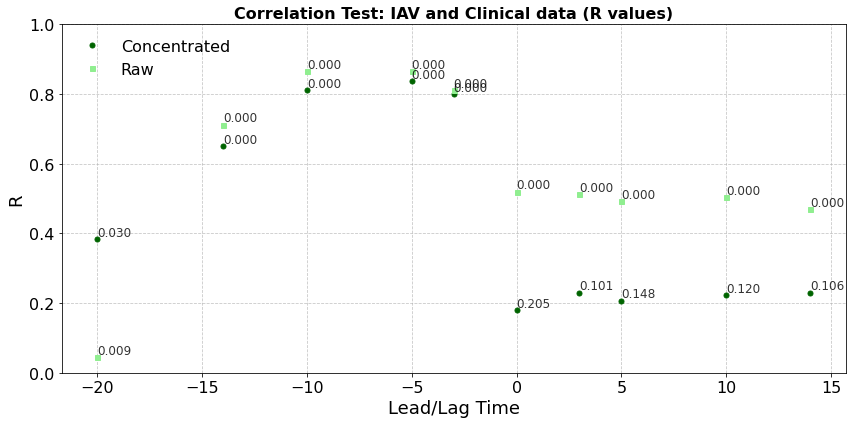

In [397]:

corr = pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\GeneXpert\PAPER1\To be submitted\Final\STOTEN\Revision 1\correlation_test_flu_covid.xlsx", sheet_name="FLU")

# Extract the data for the plot
time = corr['Time']
r_concentrated = corr['R_Concentrated']
p_concentrated = corr['p_Concentrated']
r_raw = corr['R_Raw']
p_raw = corr['p_Raw']

# Figure for R values with p-values
fig_r, ax1_r = plt.subplots(figsize=(12, 6))
color_concentrated = 'darkgreen'
ax1_r.set_xlabel('Lead/Lag Time', fontsize=18)
ax1_r.set_ylabel('R', fontsize=18)
ax1_r.plot(time, r_concentrated, color=color_concentrated, marker='o', markersize=5, linewidth=0, label='Concentrated')
ax1_r.plot(time, r_raw, color='lightgreen', marker='s', markersize=5, linewidth=0, label='Raw')
ax1_r.tick_params(axis='x', labelsize=16)
ax1_r.tick_params(axis='y', labelsize=16)
ax1_r.set_ylim(0, 1)
ax1_r.set_title('Correlation Test: IAV and Clinical data (R values)', fontsize=16, fontweight='bold')
ax1_r.legend(loc='upper left', fontsize=16)
plt.xticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Set legend without a box (frameon=False) in one line
ax1_r.legend(loc='upper left', fontsize=16, frameon=False)

plt.xticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)



# Add p-values next to the markers with reduced contrast
for i in range(len(time)):
    alpha_value = 0.8  # Adjust the alpha value to control the contrast
    ax1_r.text(time[i], r_concentrated[i], f'{p_concentrated[i]:.3f}', color='black', fontsize=12,
               ha='left', va='bottom', alpha=alpha_value)
    ax1_r.text(time[i], r_raw[i], f'{p_raw[i]:.3f}', color='black', fontsize=12,
               ha='left', va='bottom', alpha=alpha_value)

plt.tight_layout()

# Show the plot
plt.show()


### 2.2. 7-Day Average for Flu Viral Loads fro IAV

In [7]:
flu = pd.DataFrame(np.zeros((int(R_Flu.shape[0]), 4)),columns=['Date','Flu_R','Flu_W','Cases']) #Creat a dataframe with size and cloumn
avg_f = pd.DataFrame(np.zeros((int(flu_final.shape[0]/3), 4)),columns=['Date','Avg_R','Avg_W','Cases']) #Creat a dataframe with size and cloumn

k=0
for i in range(2, flu_final.shape[0],3): #Because the data starts from 2
    
    avg_f.Date[k]=R_Flu.Date[i+1]
    avg_f.Avg_R[k]=np.mean(R_Flu.Flu_R[i-2:i+1])
    
    
    avg_f.Avg_W[k]=np.mean(W_Flu.Flu_W[i-2:i+1])
    k=k+1

## Clinical Data Matching
for k in range (avg_f.shape[0]):
    for j in range (clin.shape[0]):
        if clin.Report_Date[j]==avg_f.Date[k]:
            avg_f.Cases[k]=clin.Flu_Cases[j]
avg_f

# drop the last row
#avg_f = avg_f.drop(index=avg_f.index[-1])

<ipython-input-7-251a5ff1455b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_f.Avg_R[k]=np.mean(R_Flu.Flu_R[i-2:i+1])
<ipython-input-7-251a5ff1455b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_f.Avg_W[k]=np.mean(W_Flu.Flu_W[i-2:i+1])
<ipython-input-7-251a5ff1455b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_f.Date[k]=R_Flu.Date[i+1]
<ipython-input-7-251a5ff1455b>:18: SettingWithCopyWarning: 
A value is trying 

,Date,Avg_R,Avg_W,Cases
0,2022-10-18,1.420000,1.020000,235.0
1,2022-10-26,2.155023,1.029895,434.0
2,2022-11-02,11.190670,2.398984,635.0
3,2022-11-09,9.591134,5.480461,699.0
4,2022-11-16,14.500967,3.697637,547.0
5,2022-11-23,12.515482,3.233479,411.0
6,2022-11-30,2.637721,1.854923,268.0
7,2022-12-07,4.418891,1.271447,122.0
8,2022-12-14,1.546625,1.366283,69.0
9,2022-12-21,2.014199,1.000000,32.0


### 2.3. PLOT: 7-Day Avg Flu and Clinical Data Figure IAV - Saskatoon

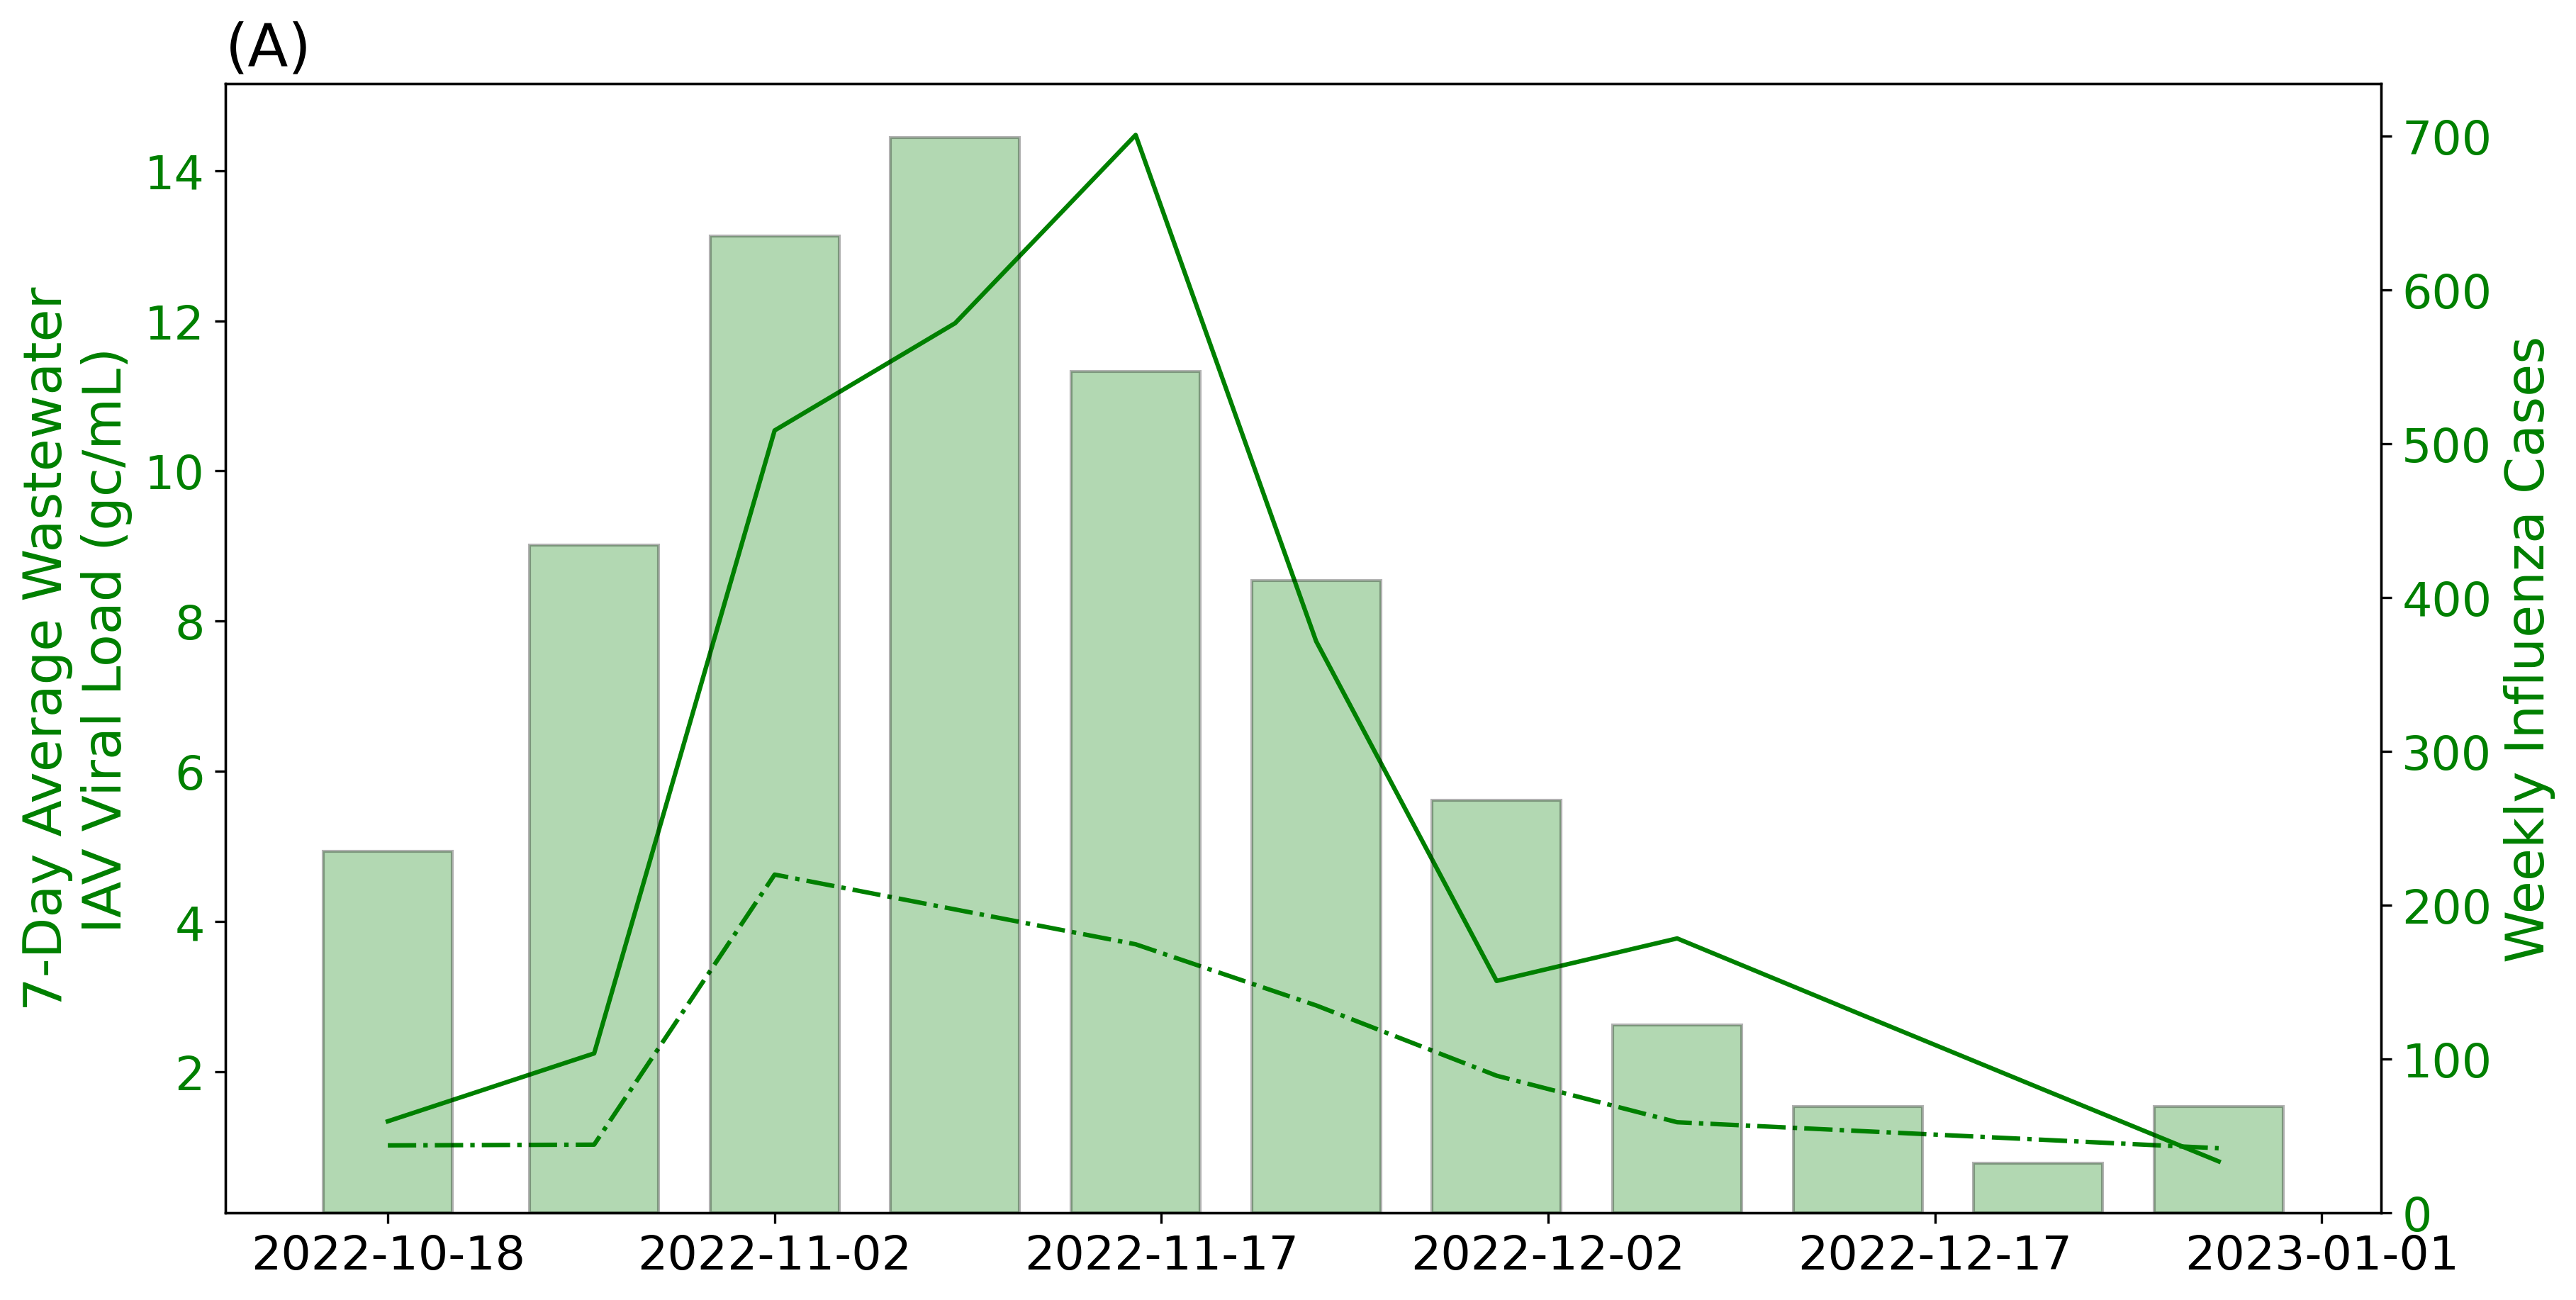

In [8]:
###FIGURE for FLU CHANGES

### Data preparation CONVERT to float & Date to intiger

#cols = R_Flu.select_dtypes(exclude=['float']).columns
#R_Flu[cols] = R_Flu[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
D = pd.to_datetime(avg_f["Date"]).dt.strftime("%Y%m%d")
D = D.astype ('int64')
R_F = avg_f.Avg_R.apply(pd.to_numeric, downcast='float', errors='coerce') ### Usedbecause the data types in excel sheet
W_F = avg_f.Avg_W.apply(pd.to_numeric, downcast='float', errors='coerce') 
avg_f_c=avg_f.Cases.apply(pd.to_numeric, downcast='float', errors='coerce')
# ------- LOWESS -------
# Generate y_hat values using lowess, try a couple values for hyperparameters
G_R = lowess(R_F, D, frac=1./2, it=2, is_sorted=True,missing='drop') #GeneXpert
G_W = lowess(W_F, D, frac=1./2, it=2, is_sorted=True,missing='drop') #GeneXpert
avg_f_cases=lowess(avg_f_c, D, frac=1./5, it=15, is_sorted=True,missing='drop')


###------------------ P L O T ------------------#



fig, ax1 = plt.subplots(figsize=(12,6),dpi=300,constrained_layout=True)
ax1.plot(avg_f.Date, G_R[:,1],'g-',avg_f.Date, G_W[:,1],'g-.')
ax1.tick_params(axis='y',labelcolor="green", labelsize=16, )

ax1.set_ylabel('7-Day Average Wastewater\n IAV Viral Load (gc/mL)',fontsize=18,color="green")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15))

#ax1.legend(['Processed Wastewater Samples','Unprocessed Wastewater Samples'],loc='best',fontsize=14)

ax2=ax1.twinx()
ax2.bar(avg_f.Date,avg_f_cases[:,1], color="green", edgecolor="black",alpha=0.3, width=5.0)
ax2.set_ylabel('Weekly Influenza Cases',fontsize=18, color="green")
ax2.tick_params(axis='y',labelcolor="green", labelsize=16, )
#ax2.legend(['Flu Cases','Unprocessed Wastewater Samples'],loc='best',fontsize=14)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=15))
#plt.tick_params(axis='x', labelrotation=90)
title=plt.title('(A)',fontsize=20)
title.set_position([0.02, 0.98])


#plt.xlabel('Sampling Date',fontsize=16)
plt.show()

#### Correlation Test for Routine and Whole Samples - Flu

# 3. SARS-CoV-2 in Saskatoon
### 3.1. Correlation test for the determination of Lead/Lag time

In [388]:
clin=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\GeneXpert\ClinicalData_CRISP_Report.xlsx",sheet_name="Sheet2")

clin[["COVID_Cases"]]= clin[["COVID_Cases"]].shift(2)

###  COVID_Analysis GENEXPERT  ####    -----    Centrifuged SAMPLES  -----------
R_Flu=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\GeneXpert\Conversion Formula_Paper1.xlsx",sheet_name="SARS-CoV-2 (SK-Routine)")

#Removing Coloumns and Rows
R_Flu.drop(['Unnamed: 0','Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 10'
           , 'Unnamed: 11','Unnamed: 12','Unnamed: 13','Unnamed: 14'],axis=1, inplace=True) #Remove Comment Column
R_Flu.drop(labels=[0,1],axis=0, inplace=True) #Remove Row with Lables 0 and 1

#Renaming
R_Flu = R_Flu.rename(columns={'Unnamed: 1':'Date','Unnamed: 6':'COVID_R'})
R_Flu.dropna(axis=0,inplace=True) # Drop NAN values

## Convert date HH MM SS to DAte
R_Flu['Date'] = pd.to_datetime(R_Flu['Date']).dt.date #Convert date HH MM SS to DAte

##                    ----------    UNCentrifuged SAMPLES  -----------
W_Flu=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\GeneXpert\Conversion Formula_Paper1.xlsx",sheet_name="SARS-CoV-2 (SK-Whole)")

#Removing Coloumns and Rows
W_Flu.drop(['Unnamed: 0','Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 10'
           , 'Unnamed: 11','Unnamed: 12','Unnamed: 13'],axis=1, inplace=True) #Remove Comment Column
W_Flu.drop(labels=[0,1],axis=0, inplace=True) #Remove Row with Lables 0 and 1

#Renaming
W_Flu = W_Flu.rename(columns={'Unnamed: 1':'Date','Unnamed: 6':'COVID_W'})
W_Flu.dropna(axis=0,inplace=True) # Drop NAN values

## Convert date HH MM SS to DAte
W_Flu.Date = pd.to_datetime(W_Flu['Date']).dt.date #Convert date HH MM SS to DAte

# ## -------     -------   COVID19 DATAset-------------------------
ii=R_Flu.shape[0]+2
jj=W_Flu.shape[0]+2
df_c = pd.DataFrame(np.zeros((W_Flu.shape[0], 3)),columns=['Date','Routine_Covid','Whole_Covid']) #Creat a dataframe with size and cloumn

i = 2 #Row starts from 16 given the data 
k = 0
for j in range (2,jj):
    if R_Flu.Date[i]==W_Flu.Date[j]:
        df_c.Date[k]=W_Flu.Date[j]
        df_c.Routine_Covid[k]=R_Flu.COVID_R[i]
        df_c.Whole_Covid[k]=W_Flu.COVID_W[j]
    k=k+1
    i=i+1

covid_final=pd.concat([R_Flu,W_Flu.COVID_W],axis=1)
covid_final["Cases"] = ""

## Clinical Data Matching
for index, row in clin.iterrows():
    date = row['Report_Date']
    cases = row['COVID_Cases']
    matching_row = covid_final[covid_final['Date'] == date]
    if not matching_row.empty:
        covid_final.loc[matching_row.index, 'Cases'] = cases

  

covid_final.dropna(axis=0,inplace=True)
#covid_final.drop(index=covid_final.index[-1],axis=0,inplace=True)
covid_final = covid_final.reset_index(drop=True)

### -------------- CORRELATION   TEST-----------###
covid_final=covid_final.dropna(axis=0)

cor_covid_case, pvalue_covid_case=spearmanr(covid_final.drop(['Date'],axis=1)) ##This is the correlation without the consoderation of time lags
  

cor_covid_case= pd.DataFrame(cor_covid_case, index=['Processed Samples','Unprocessed Samples','COVID Cases'],
                           columns=['Processed Samples','Unprocessed Samples','COVID Cases'])
pval_covid_case= pd.DataFrame(pvalue_covid_case, index=['Processed Samples','Unprocessed Samples','COVID Cases'],
                            columns=['Processed Samples','Unprocessed Samples','COVID Cases'])
frame=[cor_covid_case,pval_covid_case]
frame=pd.concat(frame)

covid_corr_test_table=cor_covid_case.iloc[[0]]
for i in range(2):
    
    covid_corr_test_table = covid_corr_test_table.append(pval_covid_case.iloc[[i]], ignore_index=True)
    covid_corr_test_table = covid_corr_test_table.append(cor_covid_case.iloc[[i+1]], ignore_index=True)
    
covid_corr_test_table = covid_corr_test_table.append(pval_covid_case.iloc[[2]], ignore_index=True) ## Add the last row indicating p-Value
covid_corr_test_table.insert(0,"Correlation Test",['R','p-value','R','p-value','R','p-value'], True)
covid_corr_test_table.insert(0,"Methodology",['COVID_R','','COVID-W','','COVID Cases',''], True)

print ("Correlation test for COVID Cases and GX results; daily-based")
covid_corr_test_table

Correlation test for COVID Cases and GX results; daily-based


<ipython-input-388-69b1e27d1ebb>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c.Routine_Covid[k]=R_Flu.COVID_R[i]
<ipython-input-388-69b1e27d1ebb>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c.Whole_Covid[k]=W_Flu.COVID_W[j]
<ipython-input-388-69b1e27d1ebb>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c.Date[k]=W_Flu.Date[j]


,Methodology,Correlation Test,Processed Samples,Unprocessed Samples,COVID Cases
0,COVID_R,R,1.000000,0.507393,0.225776
1,,p-value,0.000000,0.000169,0.114903
2,COVID-W,R,0.507393,1.000000,0.532378
3,,p-value,0.000169,0.000000,0.000069
4,COVID Cases,R,0.225776,0.532378,1.000000
5,,p-value,0.114903,0.000069,0.000000


### 3.1.1 Visualization of Correlation test for the determination of Lead/Lag time

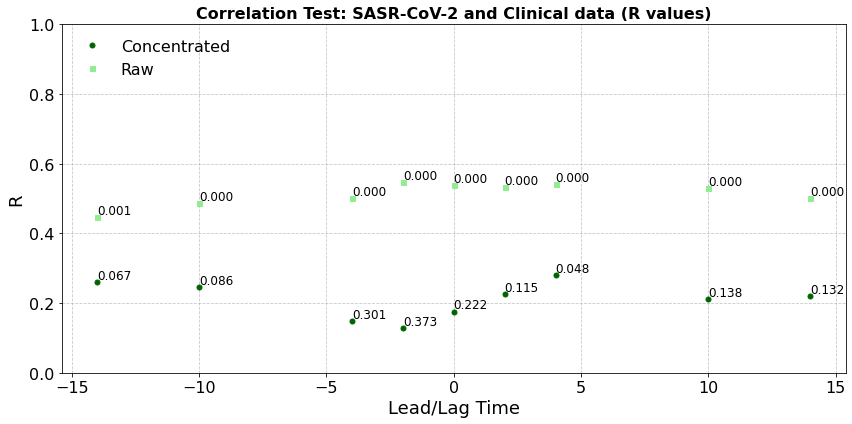

In [395]:

corr = pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\GeneXpert\PAPER1\To be submitted\Final\STOTEN\Revision 1\correlation_test_flu_covid.xlsx", sheet_name="COVID")

# Extract the data for the plot
time = corr['Time']
r_concentrated = corr['R_Concentrated']
p_concentrated = corr['p_Concentrated']
r_raw = corr['R_Raw']
p_raw = corr['p_Raw']

# Figure for R values with p-values
fig_r, ax1_r = plt.subplots(figsize=(12, 6))
color_concentrated = 'darkgreen'
ax1_r.set_xlabel('Lead/Lag Time', fontsize=18)
ax1_r.set_ylabel('R', fontsize=18)
ax1_r.plot(time, r_concentrated, color=color_concentrated, marker='o', markersize=5, linewidth=0, label='Concentrated')
ax1_r.plot(time, r_raw, color='lightgreen', marker='s', markersize=5, linewidth=0, label='Raw')
ax1_r.tick_params(axis='x', labelsize=16)
ax1_r.tick_params(axis='y', labelsize=16)
ax1_r.set_ylim(0, 1)
ax1_r.set_title('Correlation Test: SASR-CoV-2 and Clinical data (R values)', fontsize=16, fontweight='bold')
ax1_r.legend(loc='upper left', fontsize=16)
plt.xticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Set legend without a box (frameon=False) in one line
ax1_r.legend(loc='upper left', fontsize=16, frameon=False)

# Add p-values next to the markers
for i in range(len(time)):
    ax1_r.text(time[i], r_concentrated[i], f'{p_concentrated[i]:.3f}', color='black', fontsize=12, ha='left', va='bottom')
    ax1_r.text(time[i], r_raw[i], f'{p_raw[i]:.3f}', color='black', fontsize=12, ha='left', va='bottom')

plt.tight_layout()

# Show the plot
plt.show()

# 4. COVID-19 & Flu Correlatoin test

In [189]:
covid_flu = pd.DataFrame(np.zeros((flu_final.shape[0], 5)),columns=['Date','Routine_Covid','Whole_Covid','Routine_Flu','Whole_Flu']) 
for i in range (2, flu_final.shape[0]):
    for j in range (4, covid_final.shape[0]):
        if flu_final.Date[i]==covid_final.Date[j]:
            covid_flu.Date[i]=covid_final.Date[j]
            covid_flu.Routine_Covid[i]=covid_final.COVID_R[j]
            covid_flu.Whole_Covid[i]=covid_final.COVID_W[j]
            
            covid_flu.Routine_Flu[i]=flu_final.Flu_R[i]
            covid_flu.Whole_Flu[i]=flu_final.Flu_W[i]

covid_flu = covid_flu.reset_index(drop=True)
covid_flu = covid_flu[(covid_flu.T != 0).any()]  ## Drop ZERO values  
cor_covid_flu, pval_covid_flu=spearmanr(covid_flu.drop(['Date'],axis=1))



pval_covid_flu

<ipython-input-189-b1f9f43e0669>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_flu.Routine_Covid[i]=covid_final.COVID_R[j]
<ipython-input-189-b1f9f43e0669>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_flu.Whole_Covid[i]=covid_final.COVID_W[j]
<ipython-input-189-b1f9f43e0669>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_flu.Routine_Flu[i]=flu_final.Flu_R[i]
<ipython-input-189-b1f9f43e0669>:10: SettingWithCop

array([[0.00000000e+000, 6.94532887e-002, 2.34481285e-003,
        2.39795532e-002],
       [6.94532887e-002, 8.37694834e-209, 2.48950293e-002,
        5.56329893e-002],
       [2.34481285e-003, 2.48950293e-002, 8.37694834e-209,
        1.60749093e-005],
       [2.39795532e-002, 5.56329893e-002, 1.60749093e-005,
        0.00000000e+000]])

In [190]:
cor_covid_flu= pd.DataFrame(cor_covid_flu, index=['Processed COVID','Raw COVID','Processed Flu', 'Raw FLu'],
                           columns=['Processed COVID','Raw COVID','Processed Flu', 'Raw FLu'])
pval_covid_flu= pd.DataFrame(pval_covid_flu, index=['Processed COVID','Raw COVID','Processed Flu', 'Raw FLu'],
                            columns=['Processed COVID','Raw COVID','Processed Flu', 'Raw FLu'])
frame=[cor_covid_flu,pval_covid_flu]
frame=pd.concat(frame)

covid_corr_test_table=cor_covid_case.iloc[[0]]
for i in range(3):
    
    covid_corr_test_table = covid_corr_test_table.append(pval_covid_flu.iloc[[i]], ignore_index=True)
    covid_corr_test_table = covid_corr_test_table.append(cor_covid_flu.iloc[[i+1]], ignore_index=True)
    
covid_corr_test_table = covid_corr_test_table.append(pval_covid_case.iloc[[2]], ignore_index=True) ## Add the last row indicating p-Value
covid_corr_test_table.insert(0,"Correlation Test",['R','p-value','R','p-value','R','p-value','R','p-value'], True)
covid_corr_test_table.insert(0,"Methodology",['COVID_R','','COVID-W','','Flu_R','','Flu_W',''], True)

print ("Correlation test for COVID and FLU GX results; daily-based")
covid_corr_test_table

frame

Correlation test for COVID and FLU GX results; daily-based


,Processed COVID,Raw COVID,Processed Flu,Raw FLu
Processed COVID,1.000000,3.419195e-01,5.428430e-01,0.418174
Raw COVID,0.341920,1.000000e+00,4.157484e-01,0.359237
Processed Flu,0.542843,4.157484e-01,1.000000e+00,0.709938
Raw FLu,0.418174,3.592372e-01,7.099383e-01,1.000000
Processed COVID,0.000000,6.945329e-02,2.344813e-03,0.023980
Raw COVID,0.069453,8.376948e-209,2.489503e-02,0.055633
Processed Flu,0.002345,2.489503e-02,8.376948e-209,0.000016
Raw FLu,0.023980,5.563299e-02,1.607491e-05,0.000000


# 5. 7-Day Average for SARS-CoV-2 Viral Loads

In [35]:
### ------   -----   DAta Sorting
avg_c = pd.DataFrame(np.zeros((int(df_c.shape[0]/3), 5)),columns=['Date','Avg_R_C','Avg_W_C','Cases_C','Positivity_Percent']) #Creat a dataframe with size and cloumn
##Drop the last row
df_c = df_c.drop(index=df_c.index[-1])

k=0
for i in range(0, df_c.shape[0],3): #Because the data starts from 

    avg_c.Date[k]=df_c.Date[i+1]
    avg_c.Avg_R_C[k]=np.mean(df_c.Routine_Covid[i:i+3])


    avg_c.Avg_W_C[k]=np.mean(df_c.Whole_Covid[i:i+3])
    k +=1




<ipython-input-35-1c241575c13b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_c.Avg_R_C[k]=np.mean(df_c.Routine_Covid[i:i+3])
<ipython-input-35-1c241575c13b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_c.Avg_W_C[k]=np.mean(df_c.Whole_Covid[i:i+3])
<ipython-input-35-1c241575c13b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_c.Date[k]=df_c.Date[i+1]


In [41]:
## Clinical Data Matching
for i in range (avg_c.shape[0]):
    for j in range (clin.shape[0]):
        if clin.Report_Date[j]==avg_c.Date[i]:
            avg_c.Cases_C[i]=clin.COVID_Cases[j]
            
for i in range (avg_c.shape[0]):
    for j in range (clin.shape[0]):
        if clin.Report_Date[j]==avg_c.Date[i]:
            avg_c.Positivity_Percent[i]=clin.Test_Positivity_COVID_SK[j]

cor_7covid, pvalue_7covid=spearmanr(avg_c.drop(['Date','Positivity_Percent'],axis=1))
pvalue_7covid  

<ipython-input-41-583d5184c0ba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_c.Cases_C[i]=clin.COVID_Cases[j]
<ipython-input-41-583d5184c0ba>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_c.Positivity_Percent[i]=clin.Test_Positivity_COVID_SK[j]


array([[0.00000000e+000, 2.39449583e-002, 6.79977520e-001],
       [2.39449583e-002, 0.00000000e+000, 1.24014851e-002],
       [6.79977520e-001, 1.24014851e-002, 1.45441446e-116]])

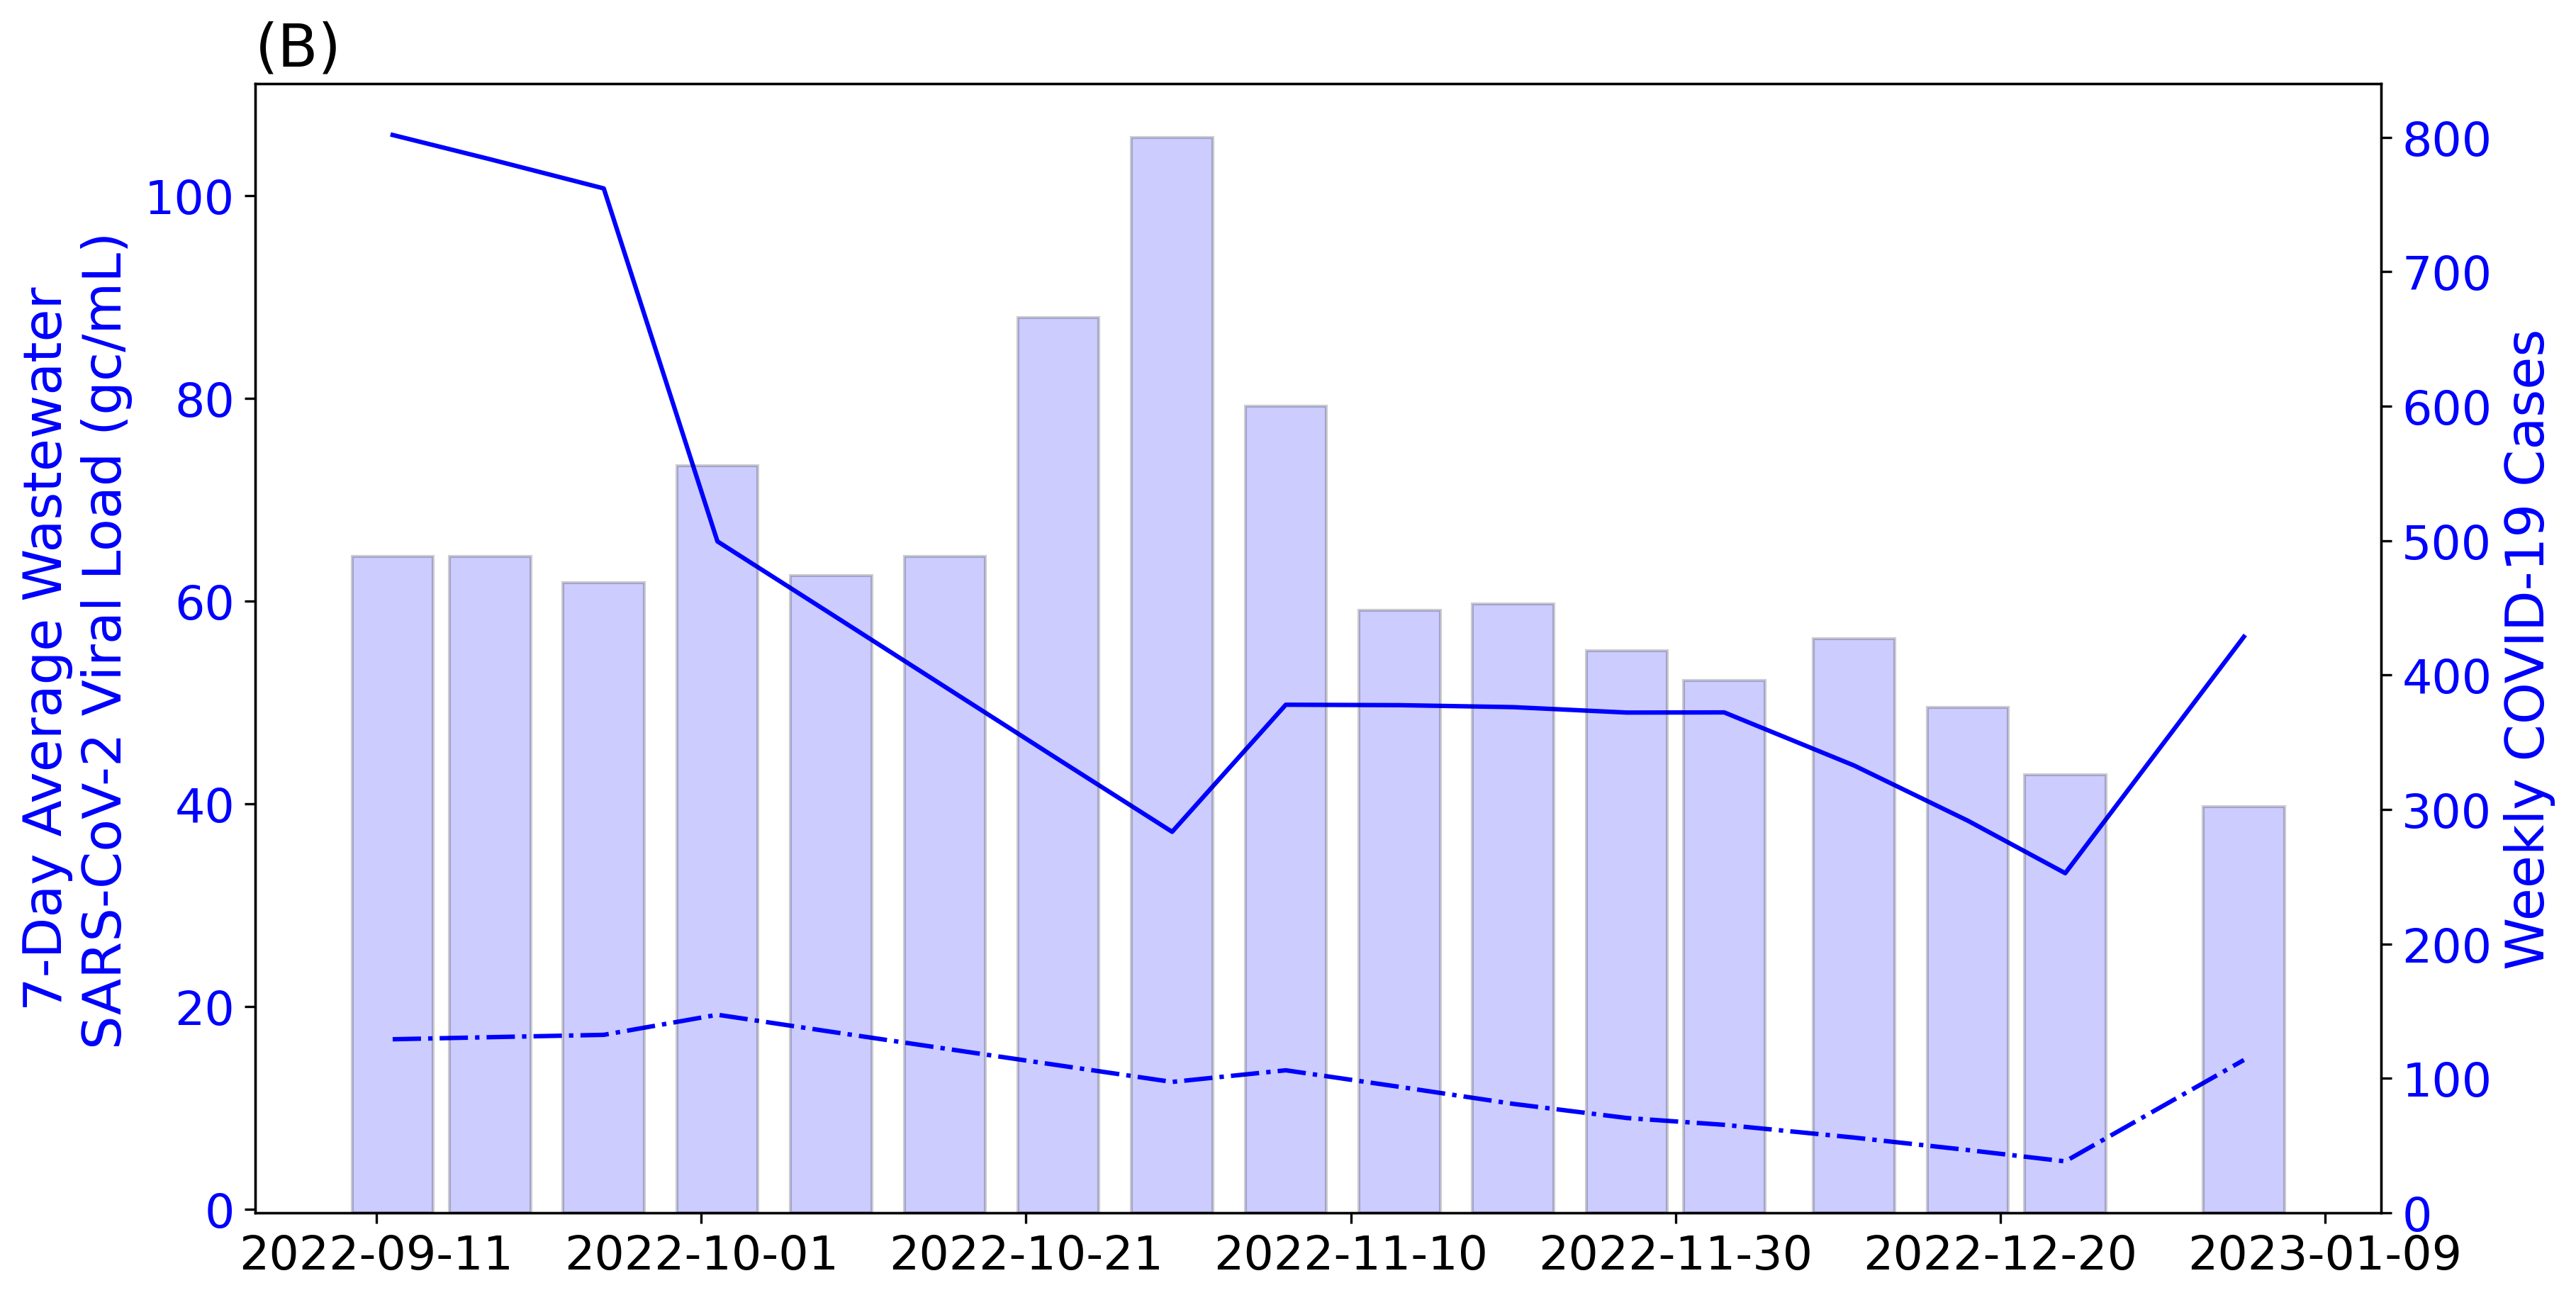

In [200]:
###FIGURE for FLU CHANGES




### Data preparation CONVERT to float & Date to intiger

#cols = R_Flu.select_dtypes(exclude=['float']).columns
#R_Flu[cols] = R_Flu[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
D = pd.to_datetime(avg_c["Date"]).dt.strftime("%Y%m%d")
D = D.astype ('int64')
R_F = avg_c.Avg_R_C.apply(pd.to_numeric, downcast='float', errors='coerce') ### Usedbecause the data types in excel sheet
W_F = avg_c.Avg_W_C.apply(pd.to_numeric, downcast='float', errors='coerce') 
avg_f_c=avg_c.Cases_C.apply(pd.to_numeric, downcast='float', errors='coerce')

# ------- LOWESS -------
# Generate y_hat values using lowess, try a couple values for hyperparameters
G_R = lowess(avg_c.Avg_R_C, D, frac=1./2.5, it=30, is_sorted=True,missing='drop') #GeneXpert
G_W = lowess(avg_c.Avg_W_C, D, frac=1./2.5, it=30, is_sorted=True,missing='drop') #GeneXpert
avg_f_cases=lowess(avg_c.Cases_C, D, frac=1./5, it=30, is_sorted=True,missing='drop')


###------------------ P L O T ------------------#



fig, ax1 = plt.subplots(figsize=(12,6),dpi=300,constrained_layout=True)
ax1.plot(avg_c.Date, G_R[:,1],'b-',avg_c.Date, G_W[:,1],'b-.')
ax1.set_ylabel('7-Day Average Wastewater\n SARS-CoV-2 Viral Load (gc/mL)',fontsize=18, color="blue")
ax1.tick_params(axis='y',labelcolor="blue", labelsize=16, )

ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
#ax1.legend(['Processed Wastewater Samples','Unprocessed Wastewater Samples'],loc='best',fontsize=14)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=20))

ax2=ax1.twinx()
ax2.bar(avg_c.Date,avg_f_c, color="blue", edgecolor="black",alpha=0.2, width=5.0)
ax2.set_ylabel('Weekly COVID-19 Cases',fontsize=18, color="blue")
ax2.tick_params(axis='y',labelcolor="blue", labelsize=16, )
#ax2.legend(['Flu Cases','Unprocessed Wastewater Samples'],loc='best',fontsize=14)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=20))

#plt.tick_params(axis='x', labelrotation=90)
title=plt.title('(B)',fontsize=20)
title.set_position([0.02, 0.98])


#plt.xlabel('Sampling Date',fontsize=16)
plt.show()


## 6. Correlation Test for Routine and Whole Samples - COVID19

## Correlation Test for Routine and Whole Samples - COVID19 & Flu

In [66]:
df_f=flu_final
df_f = df_f.reset_index(drop=True)

ii=df_c.shape[0]
jj=df_f.shape[0]
df_fc = pd.DataFrame(np.zeros((df_f.shape[0], 5)),columns=['Date','Cov_Routine','Cov_Whole','F_Routine','F_Whole']) #Creat a dataframe with size and cloumn


k = -1
for j in range (jj):
    k=k+1
    for i in range (ii):
        if df_c.Date[i]==df_f.Date[j]:
            df_fc.Date[k]=df_f.Date[j]
            df_fc.Cov_Routine[k]=df_c.Routine_Covid[i]
            df_fc.Cov_Whole[k]=df_c.Whole_Covid[i]

            df_fc.F_Routine[k]=df_f.Flu_R[j]
            df_fc.F_Whole[k]=df_f.Flu_W[j]
    
    

###  CORRELATION   TEST   ###
import scipy.stats
from scipy.stats import spearmanr
from scipy.stats import pearsonr
cor_COV_F, pvalue_COV_F=spearmanr(df_fc.drop(['Date'],axis=1))

cor_COV_F=pd.DataFrame(cor_COV_F, index=['CoV_R','CoV-W','Flu_R','Flu_W'], columns=['CoV_R','CoV-W','Flu_R','Flu_W'])
pval_COV_F=pd.DataFrame(pvalue_COV_F,index=['CoV_R','CoV-W','Flu_R','Flu_W'], columns=['CoV_R','CoV-W','Flu_R','Flu_W'])

frame=[cor_COV_F, pval_COV_F]
cor_COV_F

<ipython-input-66-004b08c74558>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fc.Cov_Routine[k]=df_c.Routine_Covid[i]
<ipython-input-66-004b08c74558>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fc.Cov_Whole[k]=df_c.Whole_Covid[i]
<ipython-input-66-004b08c74558>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fc.F_Routine[k]=df_f.Flu_R[j]
<ipython-input-66-004b08c74558>:16: SettingWithCopyWarning: 
A value is trying

,CoV_R,CoV-W,Flu_R,Flu_W
CoV_R,1.000000,0.574610,0.703920,0.627832
CoV-W,0.574610,1.000000,0.625567,0.583895
Flu_R,0.703920,0.625567,1.000000,0.829166
Flu_W,0.627832,0.583895,0.829166,1.000000


# 8. RSV Viral loads in Saskatoon, Prince Albert, and North Battleford


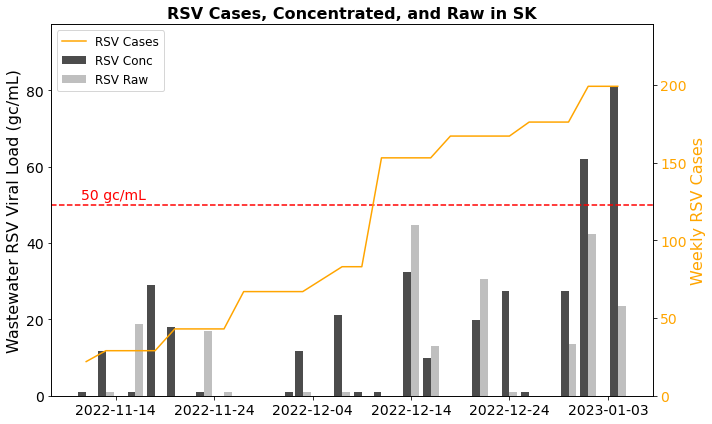

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
from scipy.stats import spearmanr
from matplotlib.ticker import MaxNLocator

# Read the Excel file with two sheets (SK and PA)
file_path = r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\GeneXpert\PAPER1\To be submitted\Final\STOTEN\Revision 1\RSV_PAPER1.xlsx"
df_sk = pd.read_excel(file_path, sheet_name="SK")

# Extract data for SK sheet
dates_sk = df_sk['Date']
rsv_conc_sk = df_sk['RSV_Conc']
rsv_raw_sk = df_sk['RSV_Raw']
rsv_cases_sk = df_sk['RSV_Cases']

# Remove rows with NaN values
df_sk.dropna(subset=['RSV_Conc', 'RSV_Raw', 'RSV_Cases'], inplace=True)

# Convert dates to numerical values
x_values = date2num(dates_sk)

# Calculate Spearman correlation coefficients and p-values for SK data
corr_conc_sk, p_conc_sk = spearmanr(df_sk['RSV_Conc'], df_sk['RSV_Cases'])
corr_raw_sk, p_raw_sk = spearmanr(df_sk['RSV_Raw'], df_sk['RSV_Cases'])

# Create the figure and axes for SK plot
fig_sk, ax_sk = plt.subplots(figsize=(10, 6))
ax_sk2 = ax_sk.twinx()  # Create the secondary y-axis

# Set the width of the bars
bar_width = 0.8

# Calculate x-coordinates for the bars
x_rsv_conc = x_values - bar_width / 2
x_rsv_raw = x_values + bar_width / 2

# Calculate the maximum values for the three columns
max_cases = rsv_cases_sk.max()
max_conc_raw = max(rsv_conc_sk.max(), rsv_raw_sk.max())

# Plot RSV_Conc and RSV_Raw as bar plots with the secondary y-axis (right y-axis)
ax_sk.bar(x_rsv_conc, rsv_conc_sk, width=bar_width, label='RSV Conc', color='k',alpha=0.7)
ax_sk.bar(x_rsv_raw, rsv_raw_sk, width=bar_width, label='RSV Raw', alpha=0.5, color='grey')
ax_sk.set_ylabel('Wastewater RSV Viral Load (gc/mL)', fontsize=16, color='k')
ax_sk.tick_params(axis='y', labelcolor='k')

# Plot RSV_Cases as a line plot with the primary y-axis (left y-axis)
ax_sk2.plot(dates_sk, rsv_cases_sk, color='orange', label='RSV Cases')
ax_sk2.set_ylabel('Weekly RSV Cases', fontsize=16, color='orange')
ax_sk2.tick_params(axis='y', labelcolor='orange')

# Add a horizontal dashed line at "50 gc/mL" and text label above it
ax_sk.axhline(y=50, color='red', linestyle='--')
ax_sk.text(0.05, 0.56, '50 gc/mL', color='red', transform=ax_sk.transAxes,
           fontsize=14, verticalalignment='top')

# Customize the appearance for SK plot
ax_sk2.set_xlabel('Date', fontsize=16)
ax_sk2.set_ylim(0, max_cases * 1.2)  # Adjust the primary y-axis limit
ax_sk.set_ylim(0, max_conc_raw * 1.2)  # Adjust the secondary y-axis limit
ax_sk2.tick_params(axis='y', labelsize=14)
ax_sk.tick_params(axis='y', labelsize=14)
ax_sk.tick_params(axis='x', labelsize=14)

# Set the x-axis tick positions and labels with MaxNLocator
num_ticks = 7
ax_sk2.xaxis.set_major_locator(MaxNLocator(num_ticks))
ax_sk2.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

# Add legend
lines_sk2, labels_sk2 = ax_sk2.get_legend_handles_labels()
lines_sk, labels_sk = ax_sk.get_legend_handles_labels()
lines = lines_sk2 + lines_sk
labels = labels_sk2 + labels_sk
ax_sk2.legend(lines, labels, fontsize=12)

plt.title('RSV Cases, Concentrated, and Raw in SK', fontsize=16, fontweight='bold')

# Show the SK plot
plt.tight_layout()
plt.show()

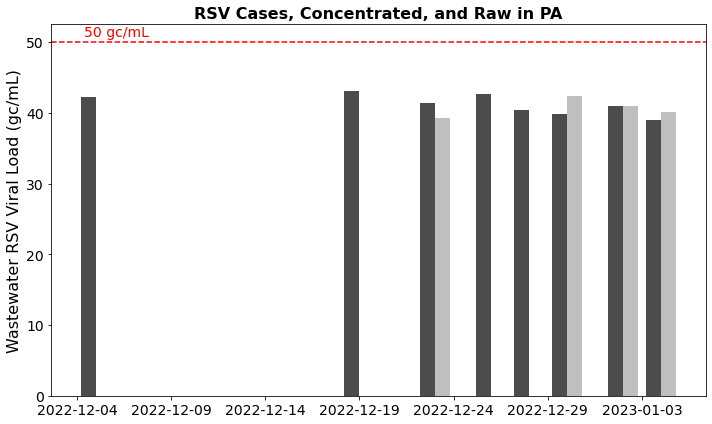

In [216]:
# Read the Excel file with two sheets (SK and PA)
file_path = r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\GeneXpert\PAPER1\To be submitted\Final\STOTEN\Revision 1\RSV_PAPER1.xlsx"
df_pa = pd.read_excel(file_path, sheet_name="PA")

# Extract data for PA sheet
dates_pa = df_pa['Date']
rsv_conc_pa = df_pa['RSV_Conc']
rsv_raw_pa = df_pa['RSV_Raw']

# Remove rows with NaN values for PA sheet
df_pa.dropna(subset=['RSV_Conc', 'RSV_Raw'], inplace=True)

# Convert dates to numerical values for PA sheet
x_values_pa = date2num(dates_pa)

# Calculate Spearman correlation coefficients and p-values for PA data
corr_conc_pa, p_conc_pa = spearmanr(df_pa['RSV_Conc'], df_pa['RSV_Cases'])
corr_raw_pa, p_raw_pa = spearmanr(df_pa['RSV_Raw'], df_pa['RSV_Cases'])

# Create the figure and axes for PA plot
fig_pa, ax_pa = plt.subplots(figsize=(10, 6))


# Set the width of the bars
bar_width = 0.8

# Calculate x-coordinates for the bars
x_rsv_conc_pa = x_values_pa - bar_width / 2
x_rsv_raw_pa = x_values_pa + bar_width / 2

# Calculate the maximum values for the two columns (Conc and Raw) for PA sheet
max_conc_raw_pa = max(rsv_conc_pa.max(), rsv_raw_pa.max())

# Plot RSV_Conc and RSV_Raw for PA sheet as bar plots with the secondary y-axis (right y-axis)
ax_pa.bar(x_rsv_conc_pa, rsv_conc_pa, width=bar_width, label='RSV Conc', color='k',alpha=0.7)
ax_pa.bar(x_rsv_raw_pa, rsv_raw_pa, width=bar_width, label='RSV Raw', alpha=0.5, color='grey')

ax_pa.set_ylabel('Wastewater RSV Viral Load (gc/mL)', fontsize=16, color='k')
ax_pa.tick_params(axis='y', labelcolor='k',labelsize=14)
ax_pa.tick_params(axis='x', labelsize=14)

# Add a horizontal dashed line at "50 gc/mL" and text label above it
ax_pa.axhline(y=50, color='red', linestyle='--')
ax_pa.text(0.05, 0.998, '50 gc/mL', color='red', transform=ax_pa.transAxes,
           fontsize=14, verticalalignment='top')


# Set the x-axis tick positions and labels with MaxNLocator
num_ticks = 7
ax_pa.xaxis.set_major_locator(MaxNLocator(num_ticks))
ax_pa.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

# Add legend
lines_pa2, labels_pa2 = ax_pa2.get_legend_handles_labels()
lines_pa, labels_pa = ax_pa.get_legend_handles_labels()
lines = lines_pa2 + lines_pa
labels = labels_pa2 + labels_pa
ax_pa2.legend(lines, labels, fontsize=14)

plt.title('RSV Cases, Concentrated, and Raw in PA', fontsize=16, fontweight='bold')

# Show the PA plot
plt.tight_layout()
plt.show()